In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# Normalize the data
X = X / 255.0

# Reshape data to 2D format expected by Flatten layer
X = X.reshape(-1, 28, 28)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the model
model = Sequential([
    Flatten(input_shape=(28, 28)),         # Flatten the input
    Dense(128, activation='relu'),         # First hidden layer
    Dense(64, activation='relu'),          # Second hidden layer
    Dense(32, activation='relu'),          # Third hidden layer
    Dense(10, activation='softmax')        # Output layer for 10 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8611 - loss: 0.4530 - val_accuracy: 0.9610 - val_loss: 0.1372
Epoch 2/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9654 - loss: 0.1119 - val_accuracy: 0.9671 - val_loss: 0.1147
Epoch 3/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9763 - loss: 0.0760 - val_accuracy: 0.9703 - val_loss: 0.1015
Epoch 4/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9832 - loss: 0.0554 - val_accuracy: 0.9710 - val_loss: 0.1012
Epoch 5/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9872 - loss: 0.0406 - val_accuracy: 0.9736 - val_loss: 0.0958
Epoch 6/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9876 - loss: 0.0371 - val_accuracy: 0.9699 - val_loss: 0.1121
Epoch 7/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9909 - loss: 0.0284 - val_accuracy: 0.9752 - val_loss: 0.1000
Epoch 8/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9921 - loss: 0.0246

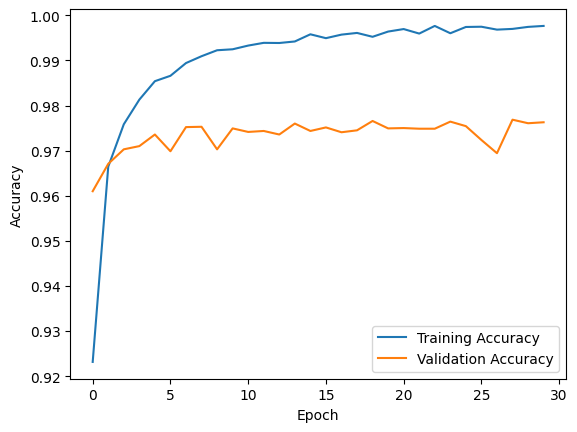

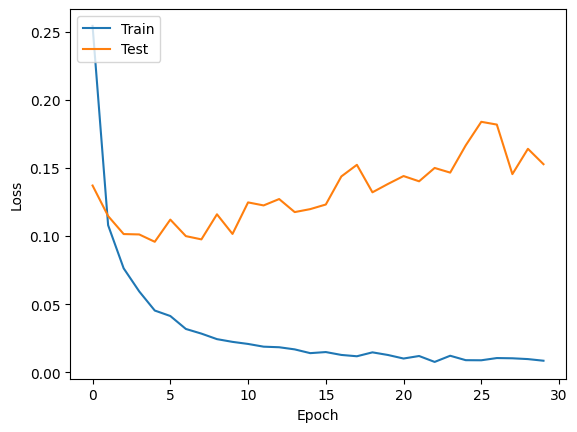

In [3]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [4]:
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Tune the number of hidden layers and units in each layer
    for i in range(hp.Int('num_layers', 1, 3)):  # 1 to 3 hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='relu'))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Tune the learning rate for the Adam optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [5]:
!pip install keras-tuner -q
from kerastuner.tuners import RandomSearch # Import the RandomSearch class from the kerastuner.tuners module
from tensorflow.keras.optimizers import Adam
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,           # Total trials to test
    executions_per_trial=1,   # Number of times to train each model
    directory='mnist_tuning', # Directory to save results
    project_name='mlp_mnist'
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


<ipython-input-5-554b0c2a57ca>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch # Import the RandomSearch class from the kerastuner.tuners module


In [6]:
# Set batch size as an additional hyperparameter
tuner.search(X_train, y_train,
             epochs=30,
             validation_data=(X_test, y_test),
             batch_size=32)


Trial 30 Complete [00h 04m 19s]
val_accuracy: 0.9792143106460571

Best val_accuracy So Far: 0.9819999933242798
Total elapsed time: 02h 01m 56s


In [7]:
# Retrieve the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of layers is {best_hps.get('num_layers')},
with the optimal units in the hidden layers as {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build and train the best model
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))



The optimal number of layers is 3,
with the optimal units in the hidden layers as [256, 128, 224],
and the optimal learning rate for the optimizer is 0.0005334045447934204.

Epoch 1/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.8746 - loss: 0.4348 - val_accuracy: 0.9629 - val_loss: 0.1272
Epoch 2/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9698 - loss: 0.0997 - val_accuracy: 0.9659 - val_loss: 0.1136
Epoch 3/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9796 - loss: 0.0627 - val_accuracy: 0.9626 - val_loss: 0.1213
Epoch 4/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9856 - loss: 0.0463 - val_accuracy: 0.9731 - val_loss: 0.0921
Epoch 5/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9882 - loss: 0.0356 - val_accuracy: 0.9739 - val_loss: 0.0931
Epoch 6/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9905 - loss: 0.0271 - val_accuracy: 0.9762 - val_loss: 0.0908
Epoch 7/30
1750/1750 ━━━━━━━━━━━━━━━━━

In [8]:
# Evaluate the best model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9808 - loss: 0.1389
Test Accuracy: 0.9796


In [9]:
import time

# Record training start time
start_time = time.time()

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_test, y_test))

# Calculate training time
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")


Epoch 1/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9981 - loss: 0.0050 - val_accuracy: 0.9818 - val_loss: 0.1344
Epoch 2/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9976 - loss: 0.0076 - val_accuracy: 0.9809 - val_loss: 0.1378
Epoch 3/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9816 - val_loss: 0.1313
Epoch 4/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9811 - val_loss: 0.1351
Epoch 5/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9987 - loss: 0.0050 - val_accuracy: 0.9794 - val_loss: 0.1371
Epoch 6/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9987 - loss: 0.0043 - val_accuracy: 0.9808 - val_loss: 0.1462
Epoch 7/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9981 - loss: 0.0066 - val_accuracy: 0.9809 - val_loss: 0.1315
Epoch 8/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9989 - loss: 0

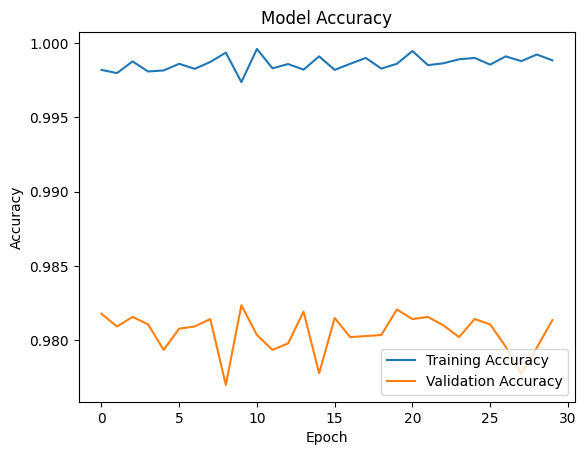

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


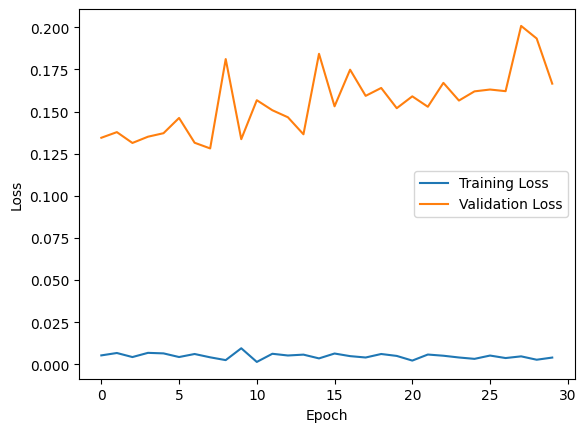

In [11]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

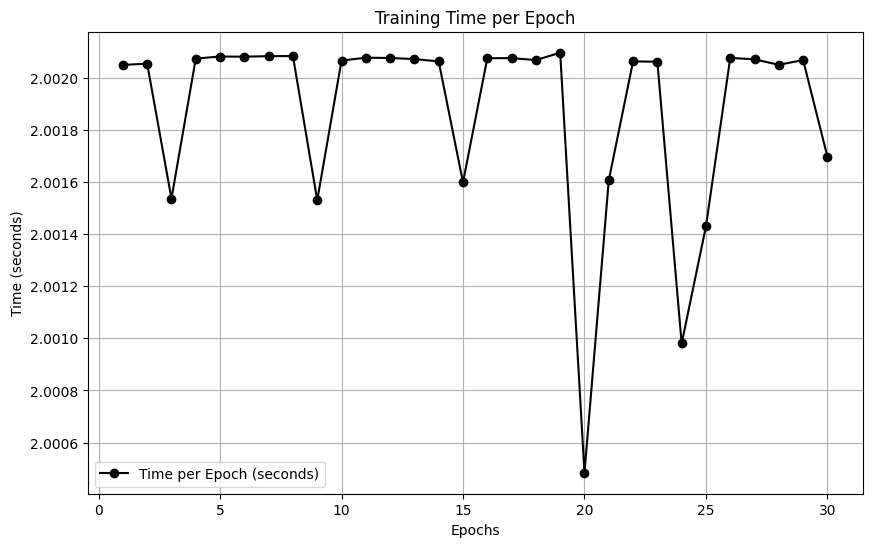

In [12]:
import matplotlib.pyplot as plt
import time

# Initialize list to store time per epoch
epoch_times = []

# Simulate the model training process and track the time per epoch
for epoch in range(1, 31):  # Loop for 30 epochs
    epoch_start_time = time.time()

    # Simulating the training code for each epoch
    # For your case, replace this with:
    # history = model.fit(x_train, y_train, epochs=1, validation_data=(x_test, y_test), batch_size=32)

    time.sleep(2)  # Simulated delay for demonstration (remove this in your real code)

    epoch_end_time = time.time()

    epoch_time = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_time)

# Plotting the training time per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), epoch_times, marker='o', linestyle='-', color='black', label='Time per Epoch (seconds)')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.grid(True)
plt.legend()
plt.show()


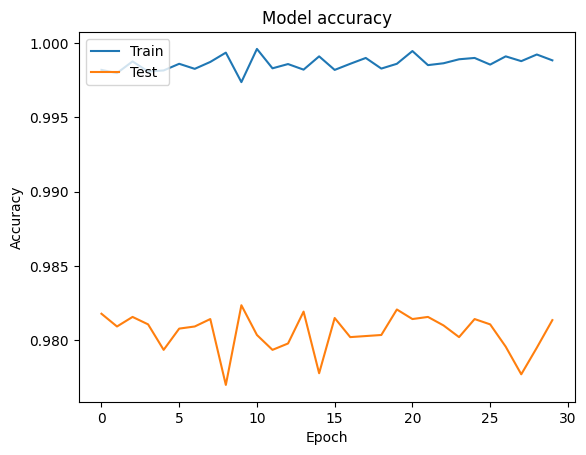

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()